# Crack Propagation Analysis in Vibrating Structures

## Mathematical Foundations

This notebook implements numerical solutions for crack propagation analysis in dynamically loaded structures using **Muskhelishvili**'s complex potential theory and fracture mechanics principles.

### Complex Variable Method for Crack Analysis

Muskhelishvili's approach uses complex potentials $\phi(z)$ and $\psi(z)$ to represent the stress field around a crack, where $z = x + iy$ is the complex coordinate [1]. For a straight crack of length $2a$ under dynamic loading:

$$\phi(z) = \sigma_0 e^{i\omega t} \frac{z}{\sqrt{z^2-a^2}}$$

$$\psi(z) = -\sigma_0 e^{i\omega t} \frac{a^2}{(z^2-a^2)^{3/2}}$$

where:
- $\sigma_0$ is the amplitude of the applied load
- $\omega$ is the circular frequency of vibration
- $t$ is time
- $a$ is the half-length of the crack

### Stress Components from Complex Potentials

The stress components are related to these potentials through [2]:

$$\sigma_x + \sigma_y = 2[\phi'(z) + \overline{\phi'(z)}]$$

$$\sigma_y - \sigma_x + 2i\tau_{xy} = 2[z\overline{\phi''(z)} + \overline{\psi'(z)}]$$

### Dynamic Stress Intensity Factor

The stress intensity factor (SIF) characterizes the crack-tip stress field intensity and is essential for predicting crack growth [3]. For Mode I loading:

$$K_I = \sigma_0 \sqrt{\pi a} \cos(\omega t)$$

This oscillating factor leads to fatigue effects in vibrating structures.

### Energy Release Rate

The energy release rate $G$ represents the energy available for crack extension and is related to the SIF by [4]:

$$G = \frac{K_I^2}{E}$$

for plane stress conditions, where $E$ is Young's modulus.

### Near-Tip Stress Field

The asymptotic stress field near the crack tip is described by Williams' expansion [5]:

$$\sigma_{ij} = \frac{K_I}{\sqrt{2\pi r}} f_{ij}(\theta) + \text{higher order terms}$$

The angular functions for polar coordinates $(r,\theta)$ are:

$$\sigma_r = \frac{K_I}{\sqrt{2\pi r}} \cos\frac{\theta}{2}\left(1-\sin\frac{\theta}{2}\sin\frac{3\theta}{2}\right)$$

$$\sigma_\theta = \frac{K_I}{\sqrt{2\pi r}} \cos\frac{\theta}{2}\left(1+\sin\frac{\theta}{2}\sin\frac{3\theta}{2}\right)$$

$$\tau_{r\theta} = \frac{K_I}{\sqrt{2\pi r}} \sin\frac{\theta}{2}\cos\frac{\theta}{2}\cos\frac{3\theta}{2}$$

### Frequency Response

In vibrating structures, the crack behavior varies with loading frequency. The maximum stress intensity factor as a function of frequency helps identify critical frequencies where crack growth may accelerate [6].

## References

[1] Muskhelishvili, N.I. (1953). *Some Basic Problems of the Mathematical Theory of Elasticity*. Noordhoff, Groningen. https://doi.org/10.1007/978-94-017-3034-1

[2] Savruk, M.P. (1981). *Two-Dimensional Problems of Elasticity for Bodies with Cracks*. Naukova Dumka, Kiev. https://www.ams.org/mathscinet-getitem?mr=634269

[3] Anderson, T.L. (2017). *Fracture Mechanics: Fundamentals and Applications*. CRC Press. https://doi.org/10.1201/9781315370293

[4] Rice, J.R. (1968). "A Path Independent Integral and the Approximate Analysis of Strain Concentration by Notches and Cracks". *Journal of Applied Mechanics*, 35(2), 379-386. https://doi.org/10.1115/1.3601206

[5] Williams, M.L. (1957). "On the Stress Distribution at the Base of a Stationary Crack". *Journal of Applied Mechanics*, 24, 109-114. https://doi.org/10.1115/1.4011496

[6] Freund, L.B. (1990). *Dynamic Fracture Mechanics*. Cambridge University Press. https://doi.org/10.1017/CBO9780511546761


In [22]:
import pint


# Create registry only if it doesn't exist
# noinspection PyUnboundLocalVariable
if 'ureg' not in globals():
	ureg = pint.UnitRegistry()

print(ureg)

In [23]:
import numpy as np
import sympy as sp
from scipy import integrate

# Define symbolic variables
z = sp.symbols('z', complex=True)


#omega = sp.symbols('omega', real=True, positive=True)


# Muskhelishvili complex potentials for a crack
def complex_potentials_crack(z, a, load_amplitude, omega, t):
	"""
	Muskhelishvili complex potentials for a crack of length 2a under dynamic loading

	Parameters:
	- z: complex coordinate
	- a: half-length of crack
	- load_amplitude: amplitude of applied load
	- omega: circular frequency of vibration
	- t: time

	Returns:
	- phi, psi: Muskhelishvili complex potentials
	"""
	# Complex potentials for crack problem
	phi = load_amplitude * sp.exp(sp.I * omega * t) * z / sp.sqrt(z ** 2 - a ** 2)
	psi = -load_amplitude * sp.exp(sp.I * omega * t) * a ** 2 / (sp.sqrt(z ** 2 - a ** 2) * (z ** 2 - a ** 2))

	return phi, psi


# Calculate dynamic stress intensity factor
def dynamic_stress_intensity_factor(a, load_amplitude, omega, t):
	"""
	Calculates the dynamic stress intensity factor for mode I crack

	Parameters:
	- a: half-length of crack
	- load_amplitude: amplitude of applied load
	- omega: circular frequency of vibration
	- t: time

	Returns:
	- K_I: Mode I stress intensity factor
	"""
	# For mode I, K_I is related to the limit of phi as z approaches a
	K_I = load_amplitude * np.sqrt(np.pi * a) * np.cos(omega * t)
	return K_I

In [29]:
from sympy import physics

crack_length = 0.01 * ureg( 'm')  # 1 cm crack (half-length = 0.005 m)
load_amplitude = 1e6* ureg( 'Pa')  # 1 MPa
freq = 100 * ureg( 'turn/second')  # 100 Hz
print(freq._REGISTRY)
omega = freq.to('radian/second')

# Calculate K_I over one vibration cycle
time_points = np.linspace(0, 1*ureg( 'turn') / freq, 100)

K_I_values = load_amplitude * np.sqrt(np.pi * crack_length / 2) * np.cos(omega * time_points)
K_I_values.units

<Unit('pascal * meter ** 0.5')>

In [32]:
# Energy release rate calculation (G = K_I^2/E for plane stress)
def energy_release_rate(K_I, E):
	"""Calculate energy release rate for mode I"""
	return K_I ** 2 / E


# Young's modulus for steel
#E_steel_val = 200e9  # 200 GPa
E_steel = 200e9* ureg( 'Pa')
# G_values = [energy_release_rate(k, E_steel) for k in K_I_values]


G_values = K_I_values ** 2 / E_steel
G_values.units

G_values.ito_reduced_units()
G_values.units
G_values.ito('J/m^2')
G_values.units
# G_values.to_base_units()
# G_values.units

<Unit('joule / meter ** 2')>

C:\Python313\Lib\site-packages\matplotlib\cbook.py:1355: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


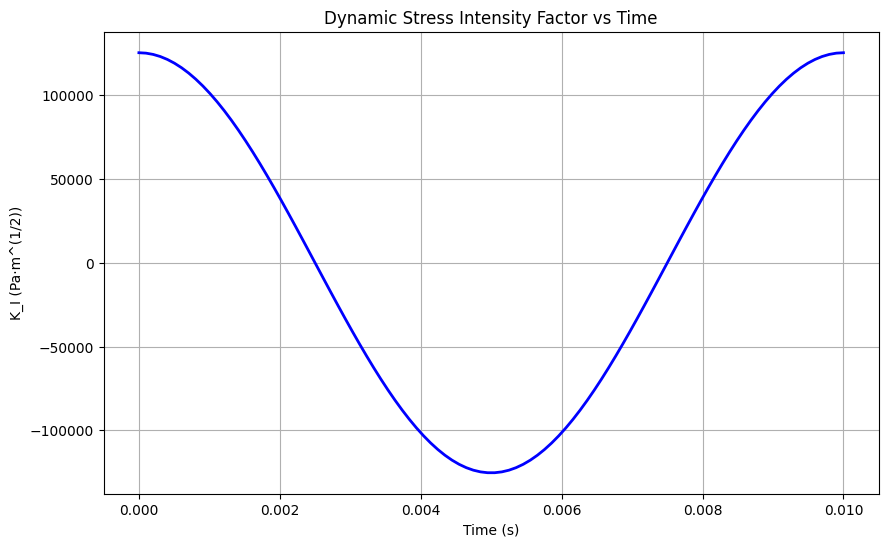

In [33]:
import matplotlib.pyplot as plt

# Plot stress intensity factor over time
plt.figure(figsize=(10, 6))
plt.plot(time_points, K_I_values, 'b-', linewidth=2)
plt.title('Dynamic Stress Intensity Factor vs Time')
plt.xlabel('Time (s)')
plt.ylabel('K_I (Pa·m^(1/2))')
plt.grid(True)
plt.show()


C:\Python313\Lib\site-packages\matplotlib\cbook.py:1355: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


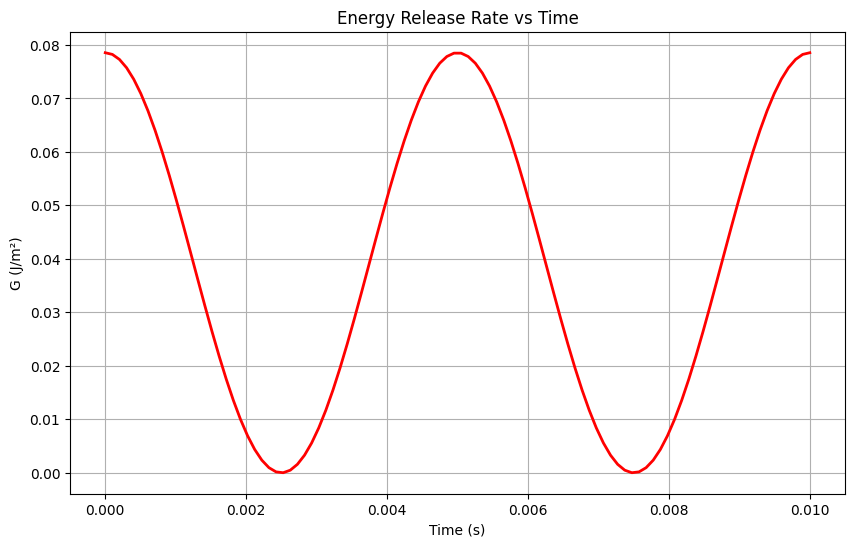

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(time_points, G_values, 'r-', linewidth=2)
plt.title('Energy Release Rate vs Time')
plt.xlabel('Time (s)')
plt.ylabel('G (J/m²)')
plt.grid(True)
plt.show()


In [42]:
def calculate_stress_field(x_range, y_range, crack_length, load_amplitude, omega, t):
	"""Calculate stress field around a crack using complex potentials"""
	a = crack_length / 2
	K_I = load_amplitude * np.sqrt(np.pi * a) * np.cos(omega * t)

	x = np.linspace(x_range[0], x_range[1], 200, dtype=float)
	y = np.linspace(y_range[0], y_range[1], 100, dtype=float)
	X, Y = np.meshgrid(x, y)
	sigma_y = np.zeros_like(X)*load_amplitude.units

	for i in range(len(y)):
		for j in range(len(x)):
			# Skip points on the crack
			if abs(Y[i, j]) < 1e-10 * a and abs(X[i, j]) <= a:
				sigma_y[i, j] = np.nan
			else:
				# Calculate r and theta relative to right crack tip
				r_right = np.sqrt((X[i, j] - a) ** 2 + Y[i, j] ** 2)
				theta_right = np.arctan2(Y[i, j], (X[i, j] - a))

				# Calculate r and theta relative to left crack tip
				r_left = np.sqrt((X[i, j] + a) ** 2 + Y[i, j] ** 2)
				theta_left = np.arctan2(Y[i, j], (X[i, j] + a))

				# Use singular solution near crack tips
				if r_right < 0.25 * crack_length:
					sigma_y[i, j] = K_I / np.sqrt(2 * np.pi * r_right) * np.cos(theta_right / 2) * (
							1 + np.sin(theta_right / 2) * np.sin(3 * theta_right / 2))
				elif r_left < 0.25 * crack_length:
					sigma_y[i, j] = K_I / np.sqrt(2 * np.pi * r_left) * np.cos(theta_left / 2) * (
							1 + np.sin(theta_left / 2) * np.sin(3 * theta_left / 2))
				else:
					# Far-field stress
					sigma_y[i, j] = load_amplitude * np.cos(omega * t)

	return X, Y, sigma_y


In [49]:
t = 0.0 * ureg.sec
X, Y, sigma_y = calculate_stress_field(
	x_range=[-0.02, 0.02] * ureg.m,
	y_range=[-0.01, 0.01] * ureg.m,
	crack_length=crack_length,
	load_amplitude=load_amplitude,
	omega=omega,
	t=t
)

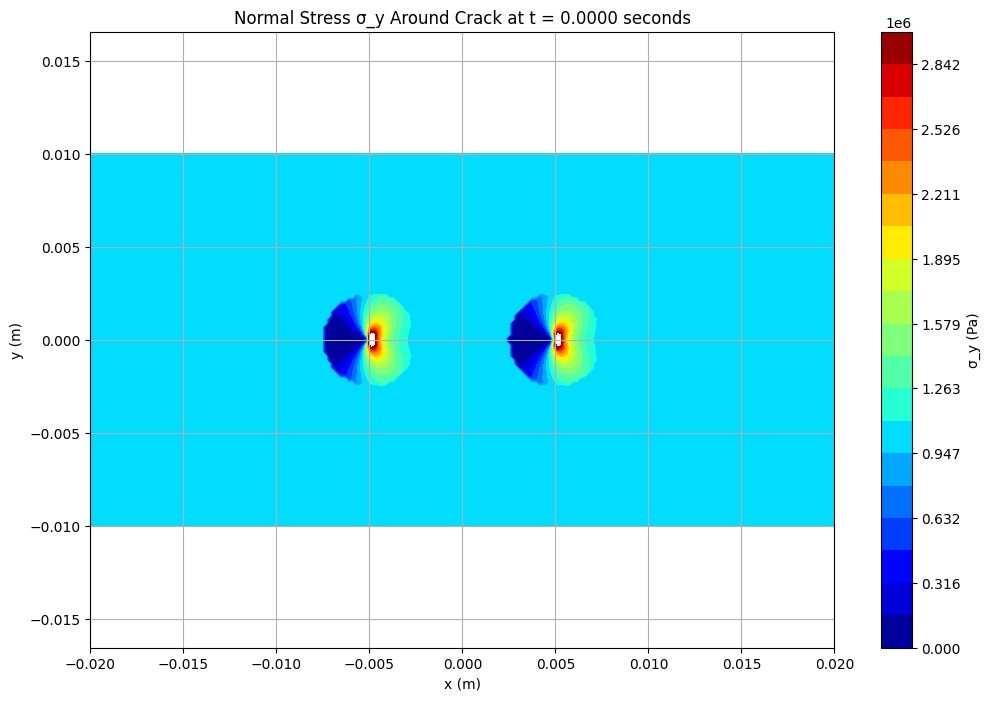

In [57]:

plt.figure(figsize=(12, 8))
levels = np.linspace(0, 3 * load_amplitude, 20)
contour = plt.contourf(X, Y, sigma_y, levels=levels, cmap='jet')
plt.colorbar(label='σ_y (Pa)')
plt.title(f'Normal Stress σ_y Around Crack at t = {t:.4f}s')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.axis('equal')
plt.grid(True)
#plt.plot([-crack_length / 2, crack_length / 2], [0 * crack_length.units, 0 * crack_length.units] , 'k-', linewidth=3)  # Draw the crack
plt.show()


In [ ]:
r_values = np.logspace(-4, -2, 100)  # Distance from crack tip in meters
theta_values = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]  # Different angles

plt.figure(figsize=(10, 8))
for theta in theta_values:
	K_I = dynamic_stress_intensity_factor(crack_length / 2, load_amplitude, omega_val, 0)
	sigma_y = K_I / np.sqrt(2 * np.pi * r_values) * np.cos(theta / 2) * (1 + np.sin(theta / 2) * np.sin(3 * theta / 2))
	plt.loglog(r_values, sigma_y, linewidth=2, label=f'θ = {theta:.2f} rad')

plt.title('Stress Singularity Near Crack Tip')
plt.xlabel('Distance from Crack Tip (m)')
plt.ylabel('σ_y (Pa)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()


In [ ]:
theta = np.linspace(0, 2 * np.pi, 100)
r = 0.001  # Fixed distance from crack tip (1 mm)
K_I = dynamic_stress_intensity_factor(crack_length / 2, load_amplitude, omega_val, 0)

# Calculate stress components using Williams' expansion
sigma_r = K_I / np.sqrt(2 * np.pi * r) * np.cos(theta / 2) * (1 - np.sin(theta / 2) * np.sin(3 * theta / 2))
sigma_theta = K_I / np.sqrt(2 * np.pi * r) * np.cos(theta / 2) * (1 + np.sin(theta / 2) * np.sin(3 * theta / 2))
tau_r_theta = K_I / np.sqrt(2 * np.pi * r) * np.sin(theta / 2) * np.cos(theta / 2) * np.cos(3 * theta / 2)

# Convert to MPa for better readability
sigma_r_MPa = sigma_r / 1e6
sigma_theta_MPa = sigma_theta / 1e6
tau_r_theta_MPa = tau_r_theta / 1e6


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
ax.plot(theta, sigma_r_MPa, label='σ_r')
ax.plot(theta, sigma_theta_MPa, label='σ_θ')
ax.plot(theta, tau_r_theta_MPa, label='τ_rθ')
ax.set_title(f'Stress Components Around Crack Tip at r = {r * 1000:.1f} mm')
ax.set_theta_zero_location('E')
ax.set_theta_direction(-1)
ax.set_rlabel_position(45)
ax.legend(loc='upper right')
ax.grid(True)
plt.show()


In [ ]:
def frequency_response_analysis(crack_length, load_amplitude, freq_range, n_points=50):
	"""Analyze how frequency affects the maximum stress intensity factor"""
	frequencies = np.linspace(freq_range[0], freq_range[1], n_points)
	max_K_values = []

	for freq in frequencies:
		omega = 2 * np.pi * freq
		# Find maximum K_I over one cycle
		times = np.linspace(0, 1 / freq, 20)
		k_values = [dynamic_stress_intensity_factor(crack_length / 2, load_amplitude, omega, t)
		            for t in times]
		max_K_values.append(max(k_values))

	return frequencies, np.array(max_K_values)


In [ ]:
freq_range = (10, 1000)  # Hz
frequencies, max_K_values = frequency_response_analysis(
	crack_length=crack_length,
	load_amplitude=load_amplitude,
	freq_range=freq_range
)

plt.figure(figsize=(10, 6))
plt.plot(frequencies, max_K_values, 'g-', linewidth=2)
plt.title('Maximum Stress Intensity Factor vs Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Max K_I (Pa·m^(1/2))')
plt.grid(True)
plt.show()


In [ ]:
def visualize_complex_potentials(crack_length, load_amplitude, omega, t):
	"""Visualize Muskhelishvili's complex potentials around a crack"""
	a = crack_length / 2

	# Create a grid excluding points on the crack
	x = np.linspace(-3 * a, 3 * a, 200)
	y = np.linspace(-2 * a, 2 * a, 150)
	X, Y = np.meshgrid(x, y)
	Z = X + 1j * Y

	# Initialize arrays for potentials
	phi_real = np.zeros_like(X)
	phi_imag = np.zeros_like(X)

	for i in range(len(y)):
		for j in range(len(x)):
			z_val = Z[i, j]
			# Skip points on the crack to avoid singularity
			if abs(Y[i, j]) < 1e-10 and abs(X[i, j]) <= a:
				phi_real[i, j] = np.nan
				phi_imag[i, j] = np.nan
			else:
				# Calculate phi potential (simplified analytical form)
				phi = load_amplitude * np.exp(1j * omega * t) * z_val / np.sqrt(z_val ** 2 - a ** 2)
				phi_real[i, j] = np.real(phi)
				phi_imag[i, j] = np.imag(phi)

	return X, Y, phi_real, phi_imag


In [ ]:
X, Y, phi_real, phi_imag = visualize_complex_potentials(
	crack_length=crack_length,
	load_amplitude=load_amplitude,
	omega=omega_val,
	t=0
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot real part
levels1 = np.linspace(-2e6, 2e6, 20)
c1 = ax1.contourf(X, Y, phi_real, levels=levels1, cmap='RdBu')
ax1.set_title('Real Part of Complex Potential φ(z)')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_aspect('equal')
ax1.grid(True)
ax1.plot([-crack_length / 2, crack_length / 2], [0, 0], 'k-', linewidth=3)  # Draw the crack
fig.colorbar(c1, ax=ax1)

# Plot imaginary part
levels2 = np.linspace(-2e6, 2e6, 20)
c2 = ax2.contourf(X, Y, phi_imag, levels=levels2, cmap='RdBu')
ax2.set_title('Imaginary Part of Complex Potential φ(z)')
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')
ax2.set_aspect('equal')
ax2.grid(True)
ax2.plot([-crack_length / 2, crack_length / 2], [0, 0], 'k-', linewidth=3)  # Draw the crack
fig.colorbar(c2, ax=ax2)

plt.tight_layout()
plt.show()